# import basic libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib as plt
import seaborn as sns 

import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)

# Import white wine dataset

In [2]:
input_DF = pd.read_csv(filepath_or_buffer='winequality-white.csv', sep=';')
X = input_DF.loc[:, input_DF.columns != 'quality']
y = input_DF[['quality']]

# Checking problem is a linear or nonlinear regression

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

In [4]:
test_for_normality_model = LinearRegression()
test_for_normality_model.fit(X,y)
print('R2 for the test model', r2_score(y_true=y, y_pred=test_for_normality_model.predict(X)))
print('RMSE for the test model', np.sqrt(mean_squared_error(y_true=y, y_pred=test_for_normality_model.predict(X))))

R2 for the test model 0.2818703641332858
RMSE for the test model 0.7504359153109988


### RMSE value is good enough to consider this as a linear problem

In [5]:
from scipy.stats import shapiro

In [6]:
pvalue = shapiro(test_for_normality_model.predict(X))[1]
print('pvalue > .5 : ', (pvalue > .5) )

pvalue > .5 :  False


### Statistically no eidence to reject null hypothesis, its a normal distribution
### Both tests indicate its linear problem

# Goodness of test with backward elimination with p value & Adj-R2

In [7]:
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant

In [8]:
def backward_elimination(X, y, significance_level):
    cols = list(X.columns)
    pmax = 1
    previous_adj_r2 = 1
    iteration_count = 0
    
    while (len(cols)>0):
        p= []
        X_1 = X[cols]
        X_1 = add_constant(X_1)
        model = OLS(y,X_1).fit()
        p = pd.Series(model.pvalues.values[1:],index = cols) 
        pmax = max(p)
        feature_with_p_max = p.idxmax()
        if(iteration_count > 0):
            if(previous_adj_r2 > model.rsquared_adj):
                break;
            else:
                previous_adj_r2 = model.rsquared_adj
                if(pmax > significance_level):
                    cols.remove(feature_with_p_max)
                else:
                    break;
        else:
            previous_adj_r2 = model.rsquared_adj
            if(pmax > significance_level):
                cols.remove(feature_with_p_max)
            else:
                break;
    return cols, X[cols]

In [9]:
important_cols, new_X = backward_elimination(X, y, significance_level=.4)
X = new_X
important_cols

['fixed acidity',
 'volatile acidity',
 'residual sugar',
 'free sulfur dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol']

# Checking for Independent features / No multi collinearity

(8.0, 0.0)

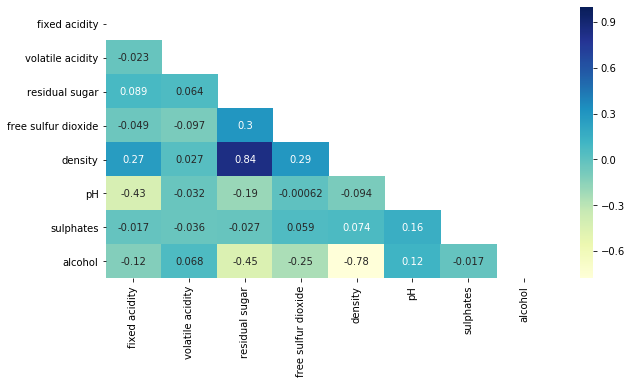

In [10]:
corr = X.corr()
plt.pyplot.subplots(figsize=(10,5))
mask = np.triu(np.ones_like(corr, dtype=np.bool))
ax = sns.heatmap(data=corr, annot=True, cmap="YlGnBu", mask=mask)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

(2.0, 0.0)

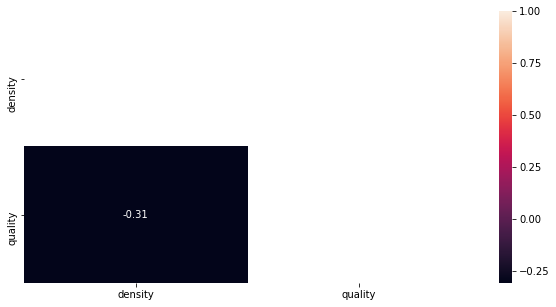

In [11]:
corr = input_DF[['density', 'quality']].corr()
plt.pyplot.subplots(figsize=(10,5))
mask = np.triu(np.ones_like(corr, dtype=np.bool))
ax = sns.heatmap(data=corr, annot=True, mask=mask)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

## As density doesnt have a string relationship with Quality need to build a model with out density

# Create Test Train splits

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

# Create simple Randomforest Regression model

In [14]:
from sklearn.ensemble import RandomForestRegressor

In [19]:
simp_forest_reg = RandomForestRegressor(n_estimators=100)
simp_forest_reg.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [20]:
def adjusted_r2(y_actual, y_pred, sample_size, feature_count):
    from sklearn.metrics import r2_score
    R2 = r2_score(y_actual, y_pred)
    n = sample_size
    p = feature_count
    Adj_r2 = 1-(1-R2)*(n-1)/(n-p-1)
    return Adj_r2

In [21]:
simp_forest_reg.score(X_test, y_test)

0.5245525269001079

### R2 & Adj-R2 for the simple model on Test data

In [22]:
print('R2 of Simple model', r2_score(y_true=y_test, y_pred=simp_tree_reg.predict(X_test)))
print('Adj-R2 of Simple model', adjusted_r2(y_test, simp_tree_reg.predict(X_test), len(X_test), len(X.columns)))

R2 of Simple model 0.5122734576833022
Adj-R2 of Simple model 0.5082551133593748


# Its not a good model for random forest